In [ ]:
%%bash
if ! conda env list | grep microexpressions; then
    conda env create -f environment.yml
else
    conda env update -f environment.yml
fi
conda activate microexpressions
dvc pull

In [2]:
import sys
import os
PROJ_PATH = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(PROJ_PATH)

Device: cuda:0

image 1/1 d:\microexpressions\data\raw\celeba\img_align_celeba\000021.jpg: 640x544 1 face, 44.7ms
Speed: 4.6ms preprocess, 44.7ms inference, 5.8ms postprocess per image at shape (1, 3, 640, 544)


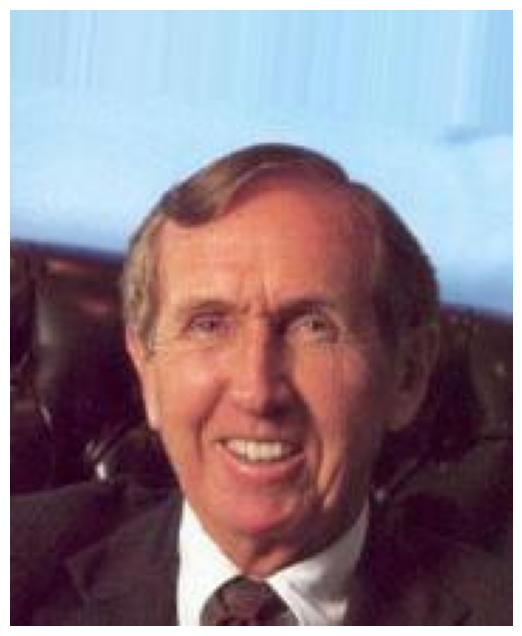

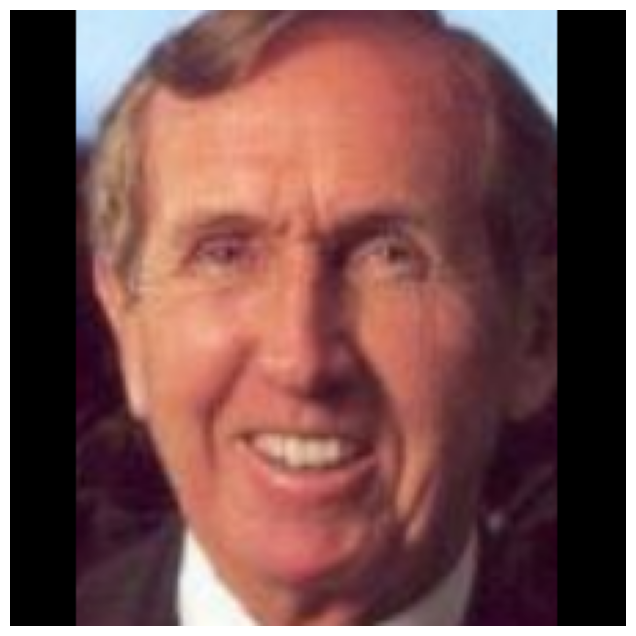

In [4]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
from src.alignment import detect_faces, align_face

PROJ_PATH = os.getcwd()
DATA_DIR = os.path.join(PROJ_PATH, 'data')
MODEL_DIR = os.path.join(PROJ_PATH, 'models')

device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")

image_path = os.path.join(DATA_DIR, "raw", r"celeba\img_align_celeba", "000021.jpg")
model_path = os.path.join(MODEL_DIR, "yolov8n-face.pt")
image, detections = detect_faces(image_path, model_path, device)

# for det in detections:
#     x1, y1, x2, y2 = map(int, det["bbox"])
#     cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 1)
#     for x, y in det["landmarks"]:
#         cv2.circle(image, (int(x), int(y)), 1, (0, 0, 255), -1)

plt.figure(figsize=(8, 8))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

aligned_image = align_face(image, np.array(detections[0]["landmarks"]), detections[0]["bbox"], output_size=(224, 224))
cv2.imwrite(r"D:\example_faces\s.jpg", aligned_image)
plt.figure(figsize=(8, 8))
plt.imshow(cv2.cvtColor(aligned_image, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

In [118]:
import pandas as pd
import os
import cv2

def plot_landmarks_cv2(image_path, landmarks):
    img = cv2.imread(image_path)
    img_height, img_width = img.shape[:2]
    for i in range(len(landmarks) // 2): 
        x = int(((landmarks[f"x{i}"] + 1) / 2) * img_width)
        y = int(((landmarks[f"y{i}"] + 1) / 2)  * img_height)
        cv2.circle(img, (x, y), radius=1, color=(0, 0, 255), thickness=-1)
    return img

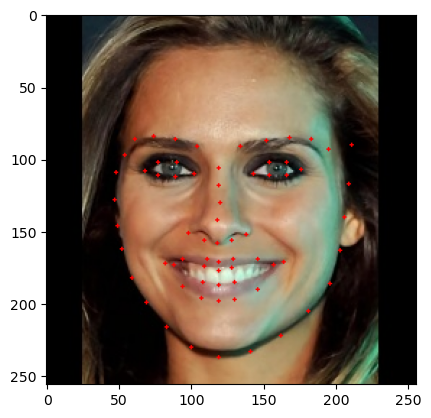

In [127]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_hdf(r"data\landmarks\landmarks_celeba_hq_pipnet.h5")
row = df.iloc[12590]
filename = row["filename"]
image_path = os.path.join(r"data\processed\aligned_celeba_hq", filename)
plt.imshow(cv2.cvtColor(plot_landmarks_cv2(image_path, row), cv2.COLOR_BGR2RGB))

<>:4: SyntaxWarning: invalid escape sequence '\m'
<>:4: SyntaxWarning: invalid escape sequence '\m'
C:\Users\SL-2577\AppData\Local\Temp\ipykernel_62168\4218712825.py:4: SyntaxWarning: invalid escape sequence '\m'
  meanface_file = "models\meanface.txt"


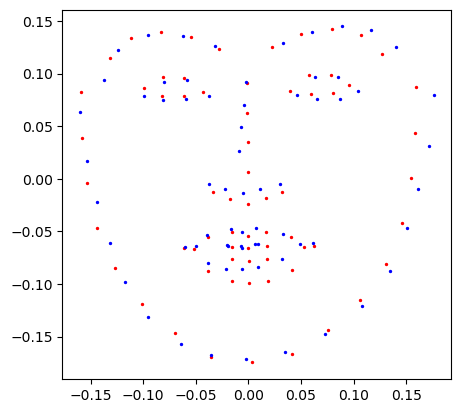

In [131]:
import numpy as np
from src.procrustes import *

meanface_file = "models\meanface.txt"
with open(meanface_file) as f:
    meanface = f.readlines()[0]

meanface = meanface.strip().split()
meanface = [float(x) for x in meanface]
meanface = np.array(meanface).reshape(-1, 2)

meanface_n = normalize_reference(meanface)
df = pd.read_hdf(r"data\landmarks\norm_landmarks_celeba_hq_pipnet.h5")
row = df.iloc[6452]
face = row[1:].to_numpy().reshape(-1, 2).astype(np.float32)

plt.scatter(meanface_n[:,0], -meanface_n[:, 1], c='red', s=2)
plt.scatter(face[:,0], -face[:, 1], c='blue', s=2)
plt.gca().set_aspect('equal')